In [22]:
'''50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．'''

# !pip install sklearn
# FORMAT: ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

path = 'data/ch6/NewsAggregatorDataset/'

df = pd.read_csv(path + 'newsCorpora.csv', sep='\t', header=None)
df.columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']

newsdataset = df.loc[df['PUBLISHER'].isin(['Reuters','Huffington Post','Businessweek','Contactmusic.com','Daily Mail'])]
newsdataset = newsdataset.sample(frac=1).reset_index(drop=True)   #shuffle all data and reset index
X = newsdataset[['TITLE','CATEGORY']]

train, valid_test = train_test_split(X, test_size=0.2)
valid, test = train_test_split(valid_test, test_size=0.5)

train.to_csv(path + 'train.txt', sep='\t', index=False, header=None)
valid.to_csv(path + 'valid.txt', sep='\t', index=False, header=None)
test.to_csv(path + 'test.txt', sep='\t', index=False, header=None)

print("train: ",Counter(train['CATEGORY']))
print("valid: ",Counter(valid['CATEGORY']))
print("test: ",Counter(test['CATEGORY']))

train:  Counter({'b': 4490, 'e': 4237, 't': 1211, 'm': 734})
valid:  Counter({'b': 589, 'e': 520, 't': 137, 'm': 88})
test:  Counter({'b': 548, 'e': 522, 't': 176, 'm': 88})


In [23]:
'''51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，
それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ．
なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．
記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．'''
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


train = pd.read_csv(path +'train.txt', sep='\t', header=None ,names=['TITLE', 'CATEGORY'])
valid = pd.read_csv(path +'valid.txt', sep='\t', header=None ,names=['TITLE', 'CATEGORY'])
test  = pd.read_csv(path +'test.txt', sep='\t', header=None ,names=['TITLE', 'CATEGORY'])

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train['TITLE'])
X_valid = vectorizer.transform(valid['TITLE'])
X_test = vectorizer.transform(test['TITLE'])

pd.DataFrame(X_train.toarray()).to_csv(path +'train_feature.txt', sep='\t', index=False, header=None)
pd.DataFrame(X_valid.toarray()).to_csv(path +'valid_feature.txt', sep='\t', index=False, header=None)
pd.DataFrame(X_test.toarray()).to_csv(path  +'test_feature.txt', sep='\t', index=False, header=None)

In [7]:
'''52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．'''

from sklearn.linear_model import LogisticRegression

X_train = pd.read_csv(path + 'train_feature.txt',sep='\t', header=None)
y_train = pd.read_csv(path + 'train.txt',sep='\t', header=None)[1]

clf = LogisticRegression(max_iter=3000)
clf.fit(X_train, y_train)
print(clf)

LogisticRegression(max_iter=3000)


In [25]:
'''53. 予測
52で学習したロジスティック回帰モデルを用い，
与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．
'''
y_train_pred = clf.predict(X_train)
print(y_train_pred)


'''54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，
学習データおよび評価データ上で計測せよ．'''

from sklearn.metrics import accuracy_score

X_valid = pd.read_csv(path + 'valid_feature.txt',sep='\t', header=None)
y_valid = pd.read_csv(path + 'valid.txt',sep='\t', header=None)[1]

X_test = pd.read_csv(path + 'test_feature.txt',sep='\t', header=None)
y_test = pd.read_csv(path + 'test.txt',sep='\t', header=None)[1]

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('train acc: ',accuracy_score(y_train, y_train_pred))
print('test acc: ', accuracy_score(y_test, y_test_pred))



'''55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．'''

from sklearn.metrics import confusion_matrix


print('\ntraining dataset confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('\ntesting dataset confusion matrix')
print(confusion_matrix(y_test, y_test_pred))



'''56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．
カテゴリごとに適合率，再現率，F1スコアを求め，
カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．'''


from sklearn.metrics import precision_recall_fscore_support

precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_test_pred, average='micro')
print('\nMicro\nprecision score: {}\nrecall score: {}\nf1 score: {}\n'.format(precision,recall,f1))
precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_test_pred, average='macro')
print('Macro\nprecision score: {}\nrecall score: {}\nf1 score: {}\n'.format(precision,recall,f1))
precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_test_pred, average=None)
print('None\nprecision score: {}\nrecall score: {}\nf1 score: {}\n'.format(precision,recall,f1))

['m' 'm' 't' ... 't' 'b' 'e']
train acc:  1.0
test acc:  0.9055472263868066

training dataset confusion matrix
[[4502    0    0    0]
 [   0 4241    0    0]
 [   0    0  728    0]
 [   0    0    0 1201]]

testing dataset confusion matrix
[[514  18   3  13]
 [  7 511   1   3]
 [ 12  12  63   1]
 [ 33  21   2 120]]

Micro
precision score: 0.9055472263868066
recall score: 0.9055472263868066
f1 score: 0.9055472263868066

Macro
precision score: 0.9015839411349262
recall score: 0.8286526700429921
f1 score: 0.8587315199542672

None
precision score: [0.90812721 0.90925267 0.91304348 0.87591241]
recall score: [0.9379562  0.9789272  0.71590909 0.68181818]
f1 score: [0.92280072 0.94280443 0.80254777 0.76677316]



In [33]:
'''57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．'''
# resources form stackoverflow
# https://stackoverflow.com/questions/28667594/linking-sklearn-logisticregression-coefficients-to-terms-in-a-sparse-matrix-and
  
labels = ['business','entertainment','health','science and technology']
  
for c in zip(labels,clf.coef_):
    print(c[0])
    top_features = sorted(list(zip(vectorizer.get_feature_names(), c[1])),key=lambda x: (x[1]),reverse=True)[:10]
    print("top features:\n",top_features)
    bottom_features = sorted(list(zip(vectorizer.get_feature_names(), c[1])),key=lambda x: (x[1]),reverse=False)[:10]
    print("bottom features:\n",bottom_features)
    print('-'*80)

business
top features:
 [('bank', 1.938062778303614), ('fed', 1.7641833555723037), ('ecb', 1.6499986914740037), ('obamacare', 1.6047951284878035), ('yellen', 1.5840908736792165), ('ukraine', 1.490314559261935), ('euro', 1.4818975362647135), ('china', 1.4609736231452768), ('pfizer', 1.4561007964230088), ('argentina', 1.4506487417518776)]
bottom features:
 [('activision', -1.3641356109443692), ('aereo', -1.2829854681223472), ('cap', -1.2390198775382195), ('ebola', -1.1539809148327385), ('she', -1.083694484459867), ('heartbleed', -1.038659360991059), ('sony', -0.9536628222444056), ('fcc', -0.9530970166497248), ('gay', -0.9117944062765752), ('subscription', -0.911644760589598)]
--------------------------------------------------------------------------------
entertainment
top features:
 [('chris', 1.6529140788144248), ('kardashian', 1.6315118546066742), ('paul', 1.6121329799920774), ('thrones', 1.3632989160896418), ('transformers', 1.3589957059520246), ('movie', 1.3156606362180596), ('miley

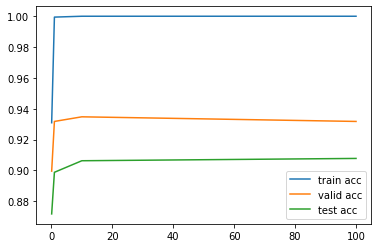

In [37]:
'''58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，
学習時の過学習（overfitting）の度合いを制御できる．
異なる正則化パラメータでロジスティック回帰モデルを学習し，
学習データ，検証データ，および評価データ上の正解率を求めよ．
実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．'''
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

X_valid = pd.read_csv(path+ 'valid_feature.txt',sep='\t', header=None)
y_valid = pd.read_csv(path+ 'valid.txt',sep='\t', header=None)[1]

c_parameters = [0.1,1,10,100]
trn_acc, val_acc, tst_acc = [],[],[]

for c in c_parameters:
    clf = LogisticRegression(C=c)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_valid_pred = clf.predict(X_valid)
    y_test_pred = clf.predict(X_test)
    
    trn_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_valid, y_valid_pred))
    tst_acc.append(accuracy_score(y_test, y_test_pred))
    
plt.plot(c_parameters, trn_acc, label='train acc')
plt.plot(c_parameters, val_acc, label='valid acc')
plt.plot(c_parameters, tst_acc,  label='test acc')
plt.legend()
plt.show()

In [8]:
'''59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．
検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．
また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．
'''
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X_trn = pd.concat([X_train,X_valid],axis=0)
y_trn =  pd.concat([y_train,y_valid],axis=0)

c_params = [0.01, 0.1, 1, 10]
sol = ['newton-cg', 'lbfgs', 'liblinear']

param_grid = dict(C=c_params, solver = sol)

clf = LogisticRegression(dual = False, max_iter=3000)
# decide params by cross-validation default: 5 fold
grid = GridSearchCV(estimator=clf, param_grid=param_grid)
grid_result = grid.fit(X_trn, y_trn)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

y_test_pred = grid.predict(X_test)
print('test acc: ', accuracy_score(y_test, y_test_pred))


Best Score:  0.8738963538991698
Best Params:  {'C': 0.1, 'solver': 'lbfgs'}
test acc:  0.8733133433283359
